<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/base_models_Conv_STHyMOUNTAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

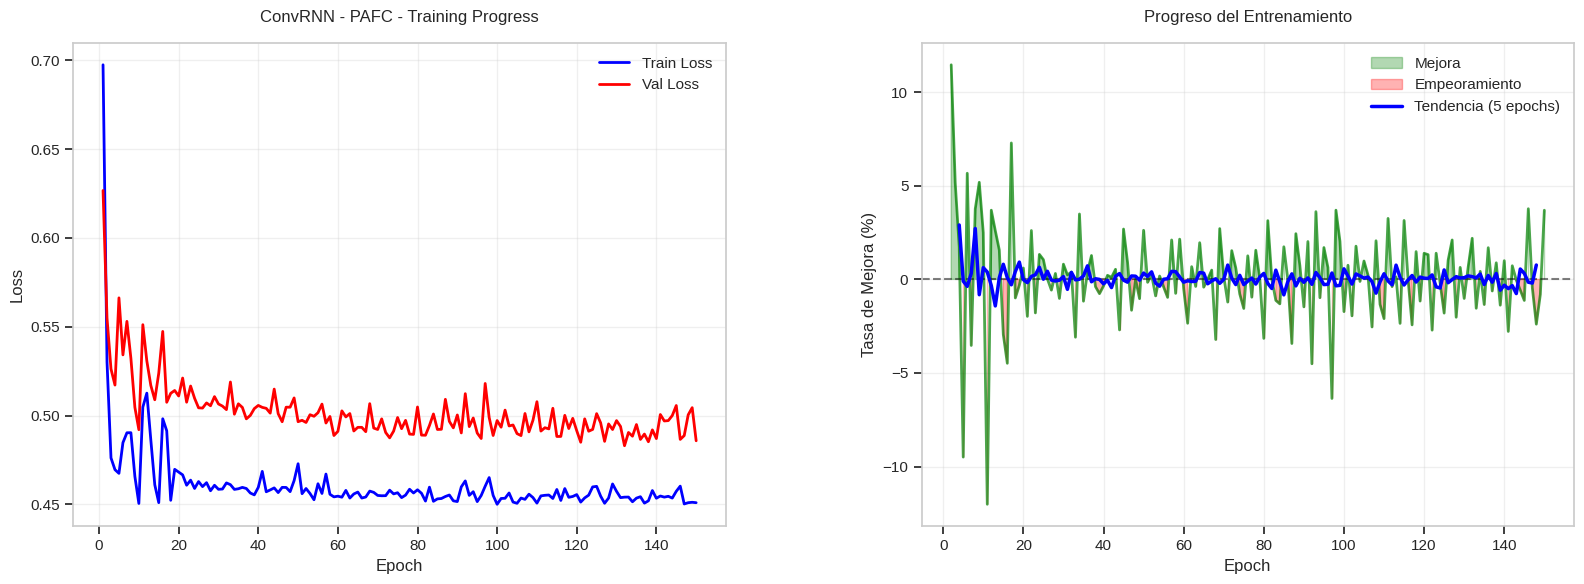


📊 Época 150/150
   • Loss: 0.450974
   • Val Loss: 0.485827
   • MAE: 0.514924
   • Val MAE: 0.528614
   • Learning Rate: 1.00e-03
   • Mejora: 3.69%
Restoring model weights from the end of the best epoch: 132.

   📊 Resumen de entrenamiento ConvRNN - PAFC:
      • Épocas totales: 150
      • Loss final (train): 0.450974
      • Loss final (val): 0.485827
      • Mejor loss (val): 0.483043 en época 132
      • Learning rate final: No disponible


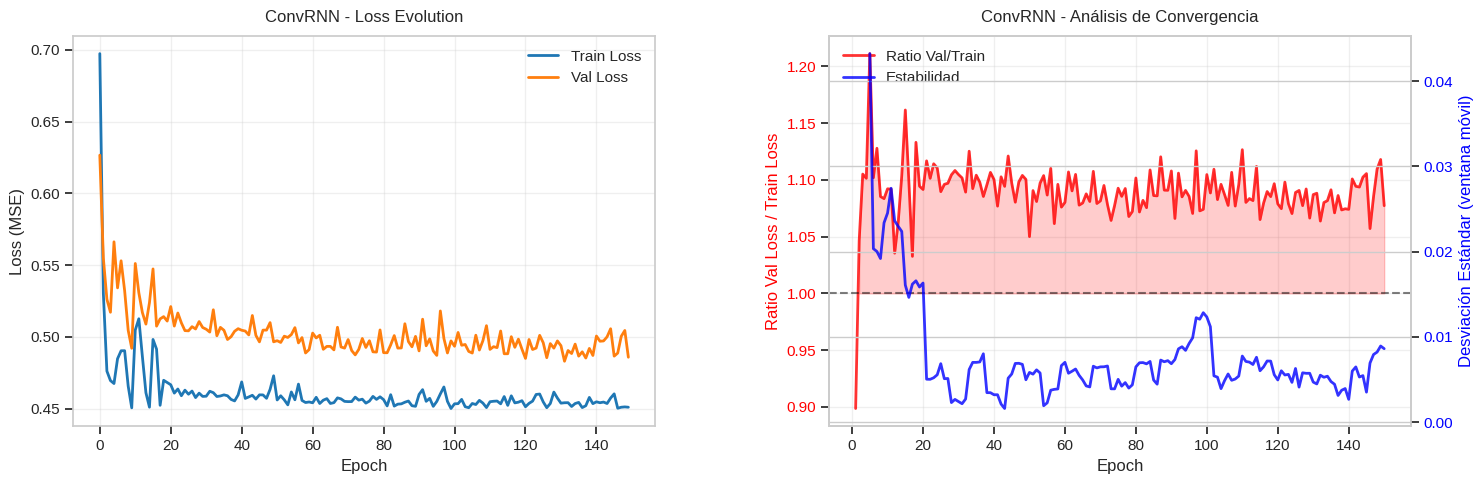


🎯 Generando predicciones...
   📈 H=1: RMSE=45.8071, MAE=37.8195, R²=0.7413
   📈 H=2: RMSE=54.8029, MAE=42.8784, R²=-0.7138
   📈 H=3: RMSE=77.5242, MAE=54.0656, R²=0.5422

📑 Metrics saved → /content/drive/MyDrive/ml_precipitation_prediction/models/output/Spatial_CONVRNN/metrics_spatial.csv


In [1]:
# ───────────────────────── IMPORTS ─────────────────────────
from __future__ import annotations
from pathlib import Path
import sys, os, gc, warnings
import numpy as np, pandas as pd, xarray as xr
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, ConvLSTM2D, SimpleRNN, Flatten, Dense, Reshape,
    Lambda, Permute, Layer, TimeDistributed
)
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, Callback
import json
from datetime import datetime
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# Detectar si estamos en Colab
IN_COLAB = 'google.colab' in sys.modules

# Instalar dependencias solo si estamos en Colab
if IN_COLAB:
    print("🔧 Detectado Google Colab. Instalando dependencias...")
    try:
        # Instalar dependencias del sistema para cartopy
        !apt-get -qq update
        !apt-get -qq install libproj-dev proj-data proj-bin libgeos-dev

        # Instalar paquetes Python en orden correcto
        !pip install -q --upgrade pip
        !pip install -q numpy pandas xarray netCDF4
        !pip install -q matplotlib seaborn
        !pip install -q scikit-learn
        !pip install -q geopandas
        !pip install -q --no-binary cartopy cartopy
        !pip install -q imageio
        !pip install -q optuna lightgbm xgboost

        print("✅ Dependencias instaladas correctamente")
    except Exception as e:
        print(f"⚠️ Error instalando dependencias: {e}")
        print("Continuando sin algunas dependencias opcionales...")

# Importar cartopy después de la instalación
try:
    import cartopy.crs as ccrs
    CARTOPY_AVAILABLE = True
except ImportError:
    print("⚠️ Cartopy no disponible. Los mapas no se mostrarán.")
    CARTOPY_AVAILABLE = False
    ccrs = None

# ── ConvGRU2D: Implementación robusta ───────────────────────────
class ConvGRU2DCell(Layer):
    """Celda ConvGRU2D robusta y completa"""

    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        self.state_size = (filters,)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Kernel para input (z, r, h)
        self.kernel = self.add_weight(
            shape=(*self.kernel_size, input_dim, self.filters * 3),
            initializer='glorot_uniform',
            name='kernel'
        )

        # Kernel recurrente (z, r, h)
        self.recurrent_kernel = self.add_weight(
            shape=(*self.kernel_size, self.filters, self.filters * 3),
            initializer='orthogonal',
            name='recurrent_kernel'
        )

        # Bias
        self.bias = self.add_weight(
            shape=(self.filters * 3,),
            initializer='zeros',
            name='bias'
        )

        super().build(input_shape)

    def call(self, inputs, states):
        h_tm1 = states[0]  # Estado anterior

        # Convoluciones para input
        x_conv = K.conv2d(inputs, self.kernel, padding=self.padding)
        x_z, x_r, x_h = tf.split(x_conv, 3, axis=-1)

        # Convoluciones para estado recurrente
        h_conv = K.conv2d(h_tm1, self.recurrent_kernel, padding=self.padding)
        h_z, h_r, h_h = tf.split(h_conv, 3, axis=-1)

        # Bias
        b_z, b_r, b_h = tf.split(self.bias, 3)

        # Gates
        z = self.recurrent_activation(x_z + h_z + b_z)  # Update gate
        r = self.recurrent_activation(x_r + h_r + b_r)  # Reset gate

        # Candidate hidden state
        h_candidate = self.activation(x_h + r * h_h + b_h)

        # New hidden state
        h = (1 - z) * h_tm1 + z * h_candidate

        return h, [h]

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'activation': tf.keras.activations.serialize(self.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.recurrent_activation)
        })
        return config


class ConvGRU2D(Layer):
    """ConvGRU2D completo con soporte para return_sequences"""

    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.recurrent_activation = recurrent_activation
        self.return_sequences = return_sequences
        self.cell = ConvGRU2DCell(
            filters, kernel_size, padding, activation, recurrent_activation
        )

    def build(self, input_shape):
        self.cell.build(input_shape[2:])  # Sin batch y time
        super().build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch, time, height, width, channels)
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        height = tf.shape(inputs)[2]
        width = tf.shape(inputs)[3]

        # Estado inicial
        initial_state = tf.zeros((batch_size, height, width, self.filters))

        # Procesar secuencia
        outputs = []
        state = initial_state

        for t in range(inputs.shape[1]):
            output, [state] = self.cell(inputs[:, t], [state])
            outputs.append(output)

        outputs = tf.stack(outputs, axis=1)

        if self.return_sequences:
            return outputs
        else:
            return outputs[:, -1]

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'activation': self.activation,
            'recurrent_activation': self.recurrent_activation,
            'return_sequences': self.return_sequences
        })
        return config

print("✅ ConvGRU2D implementado de forma robusta")

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt, seaborn as sns, geopandas as gpd, imageio.v2 as imageio
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid'); sns.set_context('notebook')

# ───────────────────────── ENTORNO / GPU ─────────────────────────
## ╭─────────────────────────── Rutas ──────────────────────────╮
# ▶️ Path configuration
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    # Instalar dependencias necesarias
    %pip install -r requirements.txt
    %pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy geopandas
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p; break

import cartopy.crs as ccrs

# limitar crecimiento de memoria‑GPU (evita OOM)
for g in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(g, True)

# ───────────────────────── PATHS & CONST ─────────────────────────
DATA_FILE = BASE_PATH/'data'/'output'/(
    'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc')
OUT_ROOT  = BASE_PATH/'models'/'output'/'Spatial_CONVRNN'
OUT_ROOT.mkdir(parents=True, exist_ok=True)
SHAPE_DIR = BASE_PATH/'data'/'input'/'shapes'
DEPT_GDF   = gpd.read_file(SHAPE_DIR/'MGN_Departamento.shp')

INPUT_WINDOW = 60
HORIZON = 3
EPOCHS = 150
BATCH = 8
LR = 1e-3
PATIENCE = 130

# ───────────────────────── FEATURE SETS ─────────────────────────
BASE_FEATS = ['year','month','month_sin','month_cos','doy_sin','doy_cos',
              'max_daily_precipitation','min_daily_precipitation','daily_precipitation_std',
              'elevation','slope','aspect']
ELEV_CLUSTER = ['elev_high','elev_med','elev_low']
KCE_FEATS = BASE_FEATS + ELEV_CLUSTER
PAFC_FEATS= KCE_FEATS + ['total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag12']
EXPERIMENTS = {'BASIC':BASE_FEATS,'KCE':KCE_FEATS,'PAFC':PAFC_FEATS}

# ───────────────────────── DATASET ─────────────────────────
ds = xr.open_dataset(DATA_FILE)
lat, lon = len(ds.latitude), len(ds.longitude)
print(f"Dataset → time={len(ds.time)}, lat={lat}, lon={lon}")

# ───────────────────────── HELPERS ─────────────────────────

def windowed_arrays(X:np.ndarray, y:np.ndarray):
    seq_X, seq_y = [], []
    T = len(X)
    for start in range(T-INPUT_WINDOW-HORIZON+1):
        end_w = start+INPUT_WINDOW; end_y=end_w+HORIZON
        Xw, yw = X[start:end_w], y[end_w:end_y]
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue
        seq_X.append(Xw); seq_y.append(yw)
    return np.asarray(seq_X,dtype=np.float32), np.asarray(seq_y,dtype=np.float32)

def quick_plot(ax,data,cmap,title,vmin=None,vmax=None,unit=None):
    if CARTOPY_AVAILABLE and ccrs is not None:
        # Versión con cartopy
        mesh = ax.pcolormesh(ds.longitude,ds.latitude,data,cmap=cmap,shading='nearest',
                             vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
        ax.coastlines()
        try:
            ax.add_geometries(DEPT_GDF.geometry,ccrs.PlateCarree(),
                             edgecolor='black',facecolor='none',linewidth=1)
        except:
            pass
        ax.gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
    else:
        # Versión sin cartopy
        mesh = ax.pcolormesh(ds.longitude,ds.latitude,data,cmap=cmap,shading='nearest',
                             vmin=vmin,vmax=vmax)
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
    ax.set_title(title,fontsize=9, pad=15)
    return mesh

# ───────────────────────── LIGHTWEIGHT HEAD ─────────────────────────

def _spatial_head(x):
    """Proyección 1×1 → (B, H,lat,lon,1) con *shape hints* para que
    Keras pueda reconstruir la capa `Lambda` al volver a cargar el modelo.
    """
    #   1) Conv 1×1 que genera H mapas (uno por horizonte)
    x = Conv2D(
        HORIZON,
        (1, 1),
        padding="same",
        activation="linear",
        name="head_conv1x1",
    )(x)  # ==> (B, lat, lon, H)

    #   2) Transponemos a (B, H, lat, lon)
    x = Lambda(
        lambda t: tf.transpose(t, [0, 3, 1, 2]),
        output_shape=(HORIZON, lat, lon),
        name="head_transpose",
    )(x)

    #   3) Añadimos eje canales: (B, H, lat, lon, 1)
    x = Lambda(
        lambda t: tf.expand_dims(t, -1),
        output_shape=(HORIZON, lat, lon, 1),
        name="head_expand_dim",
    )(x)
    return x

# ───────────────────────── MODEL FACTORIES ─────────────────────────

def build_conv_lstm(n_feats:int):
    inp = Input(shape=(INPUT_WINDOW,lat,lon,n_feats))
    x   = ConvLSTM2D(32,(3,3),padding='same',return_sequences=True)(inp)
    x   = ConvLSTM2D(16,(3,3),padding='same',return_sequences=False)(x)
    out = _spatial_head(x)
    return Model(inp, out, name='ConvLSTM')

def build_conv_gru(n_feats: int):
    """
    Construye modelo ConvGRU usando nuestra implementación robusta
    """
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Usar nuestra implementación de ConvGRU2D
    x = ConvGRU2D(32, (3, 3), padding="same", return_sequences=True)(inp)
    x = ConvGRU2D(16, (3, 3), padding="same", return_sequences=False)(x)

    out = _spatial_head(x)
    return Model(inp, out, name="ConvGRU")

def build_conv_rnn(n_feats:int):
    """
    Modelo ConvRNN corregido: procesa secuencias temporales de imágenes
    """
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Opción 1: Usar TimeDistributed para procesar cada frame
    # Aplicar convolución a cada timestep
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(inp)
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(x)

    # Aplanar cada frame para pasarlo por RNN
    x = TimeDistributed(Flatten())(x)  # (batch, time, features)

    # RNN sobre la secuencia temporal
    x = SimpleRNN(128, activation='tanh', return_sequences=False)(x)

    # Proyectar a la salida deseada
    x = Dense(HORIZON * lat * lon)(x)
    out = Reshape((HORIZON, lat, lon, 1))(x)

    return Model(inp, out, name='ConvRNN')

MODELS = {'ConvLSTM': build_conv_lstm, 'ConvGRU': build_conv_gru, 'ConvRNN': build_conv_rnn}

# ───────────────────────── TRAIN + EVAL LOOP ─────────────────────────

# Callback personalizado para visualización en tiempo real
class TrainingMonitor(Callback):
    """Callback para monitorear el entrenamiento en tiempo real"""

    def __init__(self, model_name, experiment_name):
        super().__init__()
        self.model_name = model_name
        self.experiment_name = experiment_name
        self.losses = []
        self.val_losses = []
        self.lrs = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar métricas
        self.epochs.append(epoch + 1)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        # Obtener learning rate actual
        if hasattr(self.model.optimizer, 'learning_rate'):
            try:
                lr = float(K.get_value(self.model.optimizer.learning_rate))
            except:
                lr = float(self.model.optimizer.learning_rate)
        else:
            lr = logs.get('lr', 0.001)  # Valor por defecto si no se puede obtener

        self.lrs.append(lr)

        # Limpiar output anterior
        clear_output(wait=True)

        # Crear visualización
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Plot de losses
        ax1.plot(self.epochs, self.losses, 'b-', label='Train Loss', linewidth=2)
        ax1.plot(self.epochs, self.val_losses, 'r-', label='Val Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{self.model_name} - {self.experiment_name} - Training Progress', fontsize=12, pad=15)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot de tasa de mejora y convergencia
        if len(self.val_losses) > 1:
            # Calcular tasa de mejora epoch a epoch
            improvements = []
            for i in range(1, len(self.val_losses)):
                prev_loss = self.val_losses[i-1]
                curr_loss = self.val_losses[i]
                improvement = ((prev_loss - curr_loss) / prev_loss) * 100
                improvements.append(improvement)

            # Plot de tasa de mejora
            ax2.plot(self.epochs[1:], improvements, 'g-', linewidth=2, alpha=0.7)
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax2.fill_between(self.epochs[1:], improvements, 0,
                           where=[x > 0 for x in improvements],
                           color='green', alpha=0.3, label='Mejora')
            ax2.fill_between(self.epochs[1:], improvements, 0,
                           where=[x <= 0 for x in improvements],
                           color='red', alpha=0.3, label='Empeoramiento')

            # Línea de tendencia suavizada
            if len(improvements) > 5:
                window = min(5, len(improvements)//3)
                smoothed = pd.Series(improvements).rolling(window=window, center=True).mean()
                ax2.plot(self.epochs[1:], smoothed, 'b-', linewidth=2.5,
                        label=f'Tendencia ({window} epochs)')

            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Tasa de Mejora (%)')
            ax2.set_title('Progreso del Entrenamiento', fontsize=12, pad=15)
            ax2.legend(loc='best')
            ax2.grid(True, alpha=0.3)

            # Añadir anotación de convergencia
            if len(improvements) > 10:
                recent_avg = np.mean(improvements[-5:])
                if abs(recent_avg) < 0.5:
                    ax2.text(0.95, 0.95, '⚠️ Posible convergencia',
                            transform=ax2.transAxes, ha='right', va='top',
                            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
        else:
            ax2.text(0.5, 0.5, 'Esperando más épocas...',
                    transform=ax2.transAxes, ha='center', va='center',
                    fontsize=12, color='gray')
            ax2.set_title('Progreso del Entrenamiento', fontsize=12, pad=15)
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        display(fig)
        plt.close()

        # Mostrar métricas actuales
        print(f"\n📊 Época {epoch + 1}/{self.params['epochs']}")
        print(f"   • Loss: {logs.get('loss'):.6f}")
        print(f"   • Val Loss: {logs.get('val_loss'):.6f}")
        print(f"   • MAE: {logs.get('mae'):.6f}")
        print(f"   • Val MAE: {logs.get('val_mae'):.6f}")
        print(f"   • Learning Rate: {self.lrs[-1]:.2e}")

        # Mostrar mejora
        if len(self.val_losses) > 1:
            improvement = (self.val_losses[-2] - self.val_losses[-1]) / self.val_losses[-2] * 100
            print(f"   • Mejora: {improvement:.2f}%")

# Diccionario para almacenar historiales de entrenamiento
all_histories = {}
results = []

# Función para guardar hiperparámetros
def save_hyperparameters(exp_path, model_name, hyperparams):
    """Guarda los hiperparámetros en un archivo JSON"""
    hp_file = exp_path / f"{model_name}_hyperparameters.json"
    with open(hp_file, 'w') as f:
        json.dump(hyperparams, f, indent=4)
    print(f"   💾 Hiperparámetros guardados en: {hp_file.name}")

# Función para plotear curvas de aprendizaje
def plot_learning_curves(history, exp_path, model_name, show=True):
    """Genera y guarda las curvas de aprendizaje"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title(f'{model_name} - Loss Evolution', fontsize=12, pad=10)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Análisis de Convergencia y Estabilidad
    val_losses = history.history['val_loss']
    train_losses = history.history['loss']

    if len(val_losses) > 1:
        # Calcular métricas de convergencia
        epochs = range(1, len(val_losses) + 1)

        # 1. Ratio de overfitting
        overfit_ratio = [val_losses[i] / train_losses[i] for i in range(len(val_losses))]

        # 2. Estabilidad (desviación estándar móvil)
        window = min(5, len(val_losses)//3)
        val_std = pd.Series(val_losses).rolling(window=window).std()

        # Crear subplot con dos ejes Y
        ax2_left = axes[1]
        ax2_right = ax2_left.twinx()

        # Plot ratio de overfitting
        line1 = ax2_left.plot(epochs, overfit_ratio, 'r-', linewidth=2,
                             label='Ratio Val/Train', alpha=0.8)
        ax2_left.axhline(y=1.0, color='black', linestyle='--', alpha=0.5)
        ax2_left.fill_between(epochs, 1.0, overfit_ratio,
                            where=[x > 1.0 for x in overfit_ratio],
                            color='red', alpha=0.2)
        ax2_left.set_xlabel('Epoch')
        ax2_left.set_ylabel('Ratio Val Loss / Train Loss', color='red')
        ax2_left.tick_params(axis='y', labelcolor='red')

        # Plot estabilidad
        line2 = ax2_right.plot(epochs[window-1:], val_std[window-1:], 'b-',
                             linewidth=2, label='Estabilidad', alpha=0.8)
        ax2_right.set_ylabel('Desviación Estándar (ventana móvil)', color='blue')
        ax2_right.tick_params(axis='y', labelcolor='blue')

        # Título y leyenda combinada
        ax2_left.set_title(f'{model_name} - Análisis de Convergencia', fontsize=12, pad=10)

        # Combinar leyendas
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2_left.legend(lines, labels, loc='upper left')

        ax2_left.grid(True, alpha=0.3)

        # Añadir zonas de interpretación
        if max(overfit_ratio) > 1.5:
            ax2_left.text(0.02, 0.98, '⚠️ Alto overfitting detectado',
                        transform=ax2_left.transAxes, va='top',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        elif min(val_std[window-1:]) < 0.001:
            ax2_left.text(0.02, 0.98, '✓ Entrenamiento estable',
                        transform=ax2_left.transAxes, va='top',
                        bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
    else:
        axes[1].text(0.5, 0.5, 'Insufficient data for convergence analysis',
                    transform=axes[1].transAxes, ha='center', va='center',
                    fontsize=12, color='gray')
        axes[1].set_title(f'{model_name} - Convergence Analysis', fontsize=12, pad=15)
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # Guardar
    curves_path = exp_path / f"{model_name}_learning_curves.png"
    plt.savefig(curves_path, dpi=150, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close()

    return curves_path

# Función para mostrar resumen de entrenamiento
def print_training_summary(history, model_name, exp_name):
    """Imprime un resumen del entrenamiento"""
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss) + 1

    print(f"\n   📊 Resumen de entrenamiento {model_name} - {exp_name}:")
    print(f"      • Épocas totales: {len(history.history['loss'])}")
    print(f"      • Loss final (train): {final_loss:.6f}")
    print(f"      • Loss final (val): {final_val_loss:.6f}")
    print(f"      • Mejor loss (val): {best_val_loss:.6f} en época {best_epoch}")
    if 'lr' in history.history and len(history.history['lr']) > 0:
        final_lr = history.history['lr'][-1]
        print(f"      • Learning rate final: {final_lr:.2e}")
    else:
        print(f"      • Learning rate final: No disponible")

for exp, feat_list in EXPERIMENTS.items():
    print(f"\n{'='*70}")
    print(f"🔬 EXPERIMENTO: {exp} ({len(feat_list)} features)")
    print(f"{'='*70}")

    # Preparar datos
    Xarr = ds[feat_list].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
    yarr = ds['total_precipitation'].values.astype(np.float32)[...,None]
    X, y = windowed_arrays(Xarr, yarr)
    split = int(0.8*len(X))

    sx = StandardScaler().fit(X[:split].reshape(-1,len(feat_list)))
    sy = StandardScaler().fit(y[:split].reshape(-1,1))
    X_sc = sx.transform(X.reshape(-1,len(feat_list))).reshape(X.shape)
    y_sc = sy.transform(y.reshape(-1,1)).reshape(y.shape)
    X_tr, X_va = X_sc[:split], X_sc[split:]
    y_tr, y_va = y_sc[:split], y_sc[split:]

    OUT_EXP = OUT_ROOT/exp
    OUT_EXP.mkdir(exist_ok=True)

    # Crear subdirectorio para métricas de entrenamiento
    METRICS_DIR = OUT_EXP / 'training_metrics'
    METRICS_DIR.mkdir(exist_ok=True)

    for mdl_name, builder in MODELS.items():
        print(f"\n{'─'*50}")
        print(f"🤖 Modelo: {mdl_name}")
        print(f"{'─'*50}")

        model_path = OUT_EXP/f"{mdl_name.lower()}_best.keras"
        if model_path.exists():
            model_path.unlink()

        try:
            # Construir modelo
            model = builder(n_feats=len(feat_list))

            # Definir optimizador con configuración explícita
            optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # Hiperparámetros
            hyperparams = {
                'experiment': exp,
                'model': mdl_name,
                'features': feat_list,
                'n_features': len(feat_list),
                'input_window': INPUT_WINDOW,
                'horizon': HORIZON,
                'batch_size': BATCH,
                'initial_lr': LR,
                'epochs': EPOCHS,
                'patience': PATIENCE,
                'train_samples': len(X_tr),
                'val_samples': len(X_va),
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'model_params': model.count_params()
            }

            # Guardar hiperparámetros
            save_hyperparameters(METRICS_DIR, mdl_name, hyperparams)

            # Callbacks mejorados
            csv_logger = CSVLogger(
                METRICS_DIR / f"{mdl_name}_training_log.csv",
                separator=',',
                append=False
            )

            reduce_lr = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=PATIENCE//2,
                min_lr=1e-6,
                verbose=1
            )

            early_stop = EarlyStopping(
                'val_loss',
                patience=PATIENCE,
                restore_best_weights=True,
                verbose=1
            )

            checkpoint = ModelCheckpoint(
                model_path,
                save_best_only=True,
                monitor='val_loss',
                verbose=1
            )

            # Agregar monitor de entrenamiento
            training_monitor = TrainingMonitor(mdl_name, exp)

            callbacks = [early_stop, checkpoint, reduce_lr, csv_logger, training_monitor]

            # Entrenar con verbose=0 para usar nuestro monitor personalizado
            print(f"\n🏃 Iniciando entrenamiento...")
            print(f"   📊 Visualización en tiempo real activada")

            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_va, y_va),
                epochs=EPOCHS,
                batch_size=BATCH,
                callbacks=callbacks,
                verbose=0  # Usar 0 para que solo se muestre nuestro monitor
            )

            # Guardar historial
            all_histories[f"{exp}_{mdl_name}"] = history

            # Mostrar resumen de entrenamiento
            print_training_summary(history, mdl_name, exp)

            # Plotear y guardar curvas de aprendizaje
            plot_learning_curves(history, METRICS_DIR, mdl_name, show=True)

            # Guardar historial como JSON
            # Obtener learning rates del monitor de entrenamiento si no están en history
            lr_values = history.history.get('lr', [])
            if not lr_values and hasattr(training_monitor, 'lrs'):
                lr_values = training_monitor.lrs

            history_dict = {
                'loss': [float(x) for x in history.history['loss']],
                'val_loss': [float(x) for x in history.history['val_loss']],
                'mae': [float(x) for x in history.history.get('mae', [])],
                'val_mae': [float(x) for x in history.history.get('val_mae', [])],
                'lr': [float(x) for x in lr_values] if lr_values else []
            }

            with open(METRICS_DIR / f"{mdl_name}_history.json", 'w') as f:
                json.dump(history_dict, f, indent=4)

            # ─ Predicciones y visualización ─
            print(f"\n🎯 Generando predicciones...")
            y_hat_sc = model.predict(X_va[-1:], verbose=0)
            y_hat = sy.inverse_transform(y_hat_sc.reshape(-1,1)).reshape(HORIZON,lat,lon)
            y_true = sy.inverse_transform(y_va[-1:].reshape(-1,1)).reshape(HORIZON,lat,lon)

            # ─ Mapas & GIF ─
            vmin, vmax = 0, max(y_true.max(), y_hat.max())
            frames = []
            dates = pd.date_range(ds.time.values[-HORIZON], periods=HORIZON, freq='MS')

            for h in range(HORIZON):
                err = np.clip(np.abs((y_true[h]-y_hat[h])/(y_true[h]+1e-5))*100, 0, 100)
                fig, axs = plt.subplots(1, 3, figsize=(18, 5), subplot_kw={'projection': ccrs.PlateCarree()})
                quick_plot(axs[0], y_true[h], 'Blues', f"Real h={h+1}", vmin, vmax, unit="mm")
                quick_plot(axs[1], y_hat[h], 'Blues', f"{mdl_name} h={h+1}", vmin, vmax)
                quick_plot(axs[2], err, 'Reds', f"MAPE% h={h+1}", 0, 100, unit="%")
                fig.suptitle(f"{mdl_name} – {exp} – {dates[h].strftime('%Y-%m')}", fontsize=14, y=0.98)
                png = OUT_EXP/f"{mdl_name}_{h+1}.png"
                fig.savefig(png, bbox_inches='tight')
                plt.close(fig)
                frames.append(imageio.imread(png))

            imageio.mimsave(OUT_EXP/f"{mdl_name}.gif", frames, fps=0.5)

            # ─ Métricas de evaluación ─
            for h in range(HORIZON):
                rmse = np.sqrt(mean_squared_error(y_true[h].ravel(), y_hat[h].ravel()))
                mae = mean_absolute_error(y_true[h].ravel(), y_hat[h].ravel())
                r2 = r2_score(y_true[h].ravel(), y_hat[h].ravel())

                results.append({
                    'Experiment': exp,
                    'Model': mdl_name,
                    'H': h+1,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2
                })

                print(f"   📈 H={h+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

            tf.keras.backend.clear_session()
            gc.collect()

        except Exception as e:
            print(f"  ⚠️ Error en {mdl_name}: {str(e)}")
            print(f"  → Saltando {mdl_name} para {exp}")
            import traceback
            traceback.print_exc()
            continue

# ───────────────────────── CSV FINAL ─────────────────────────
res_df=pd.DataFrame(results)
res_df.to_csv(OUT_ROOT/'metrics_spatial.csv',index=False)
print("\n📑 Metrics saved →", OUT_ROOT/'metrics_spatial.csv')



📊 GENERANDO VISUALIZACIONES COMPARATIVAS


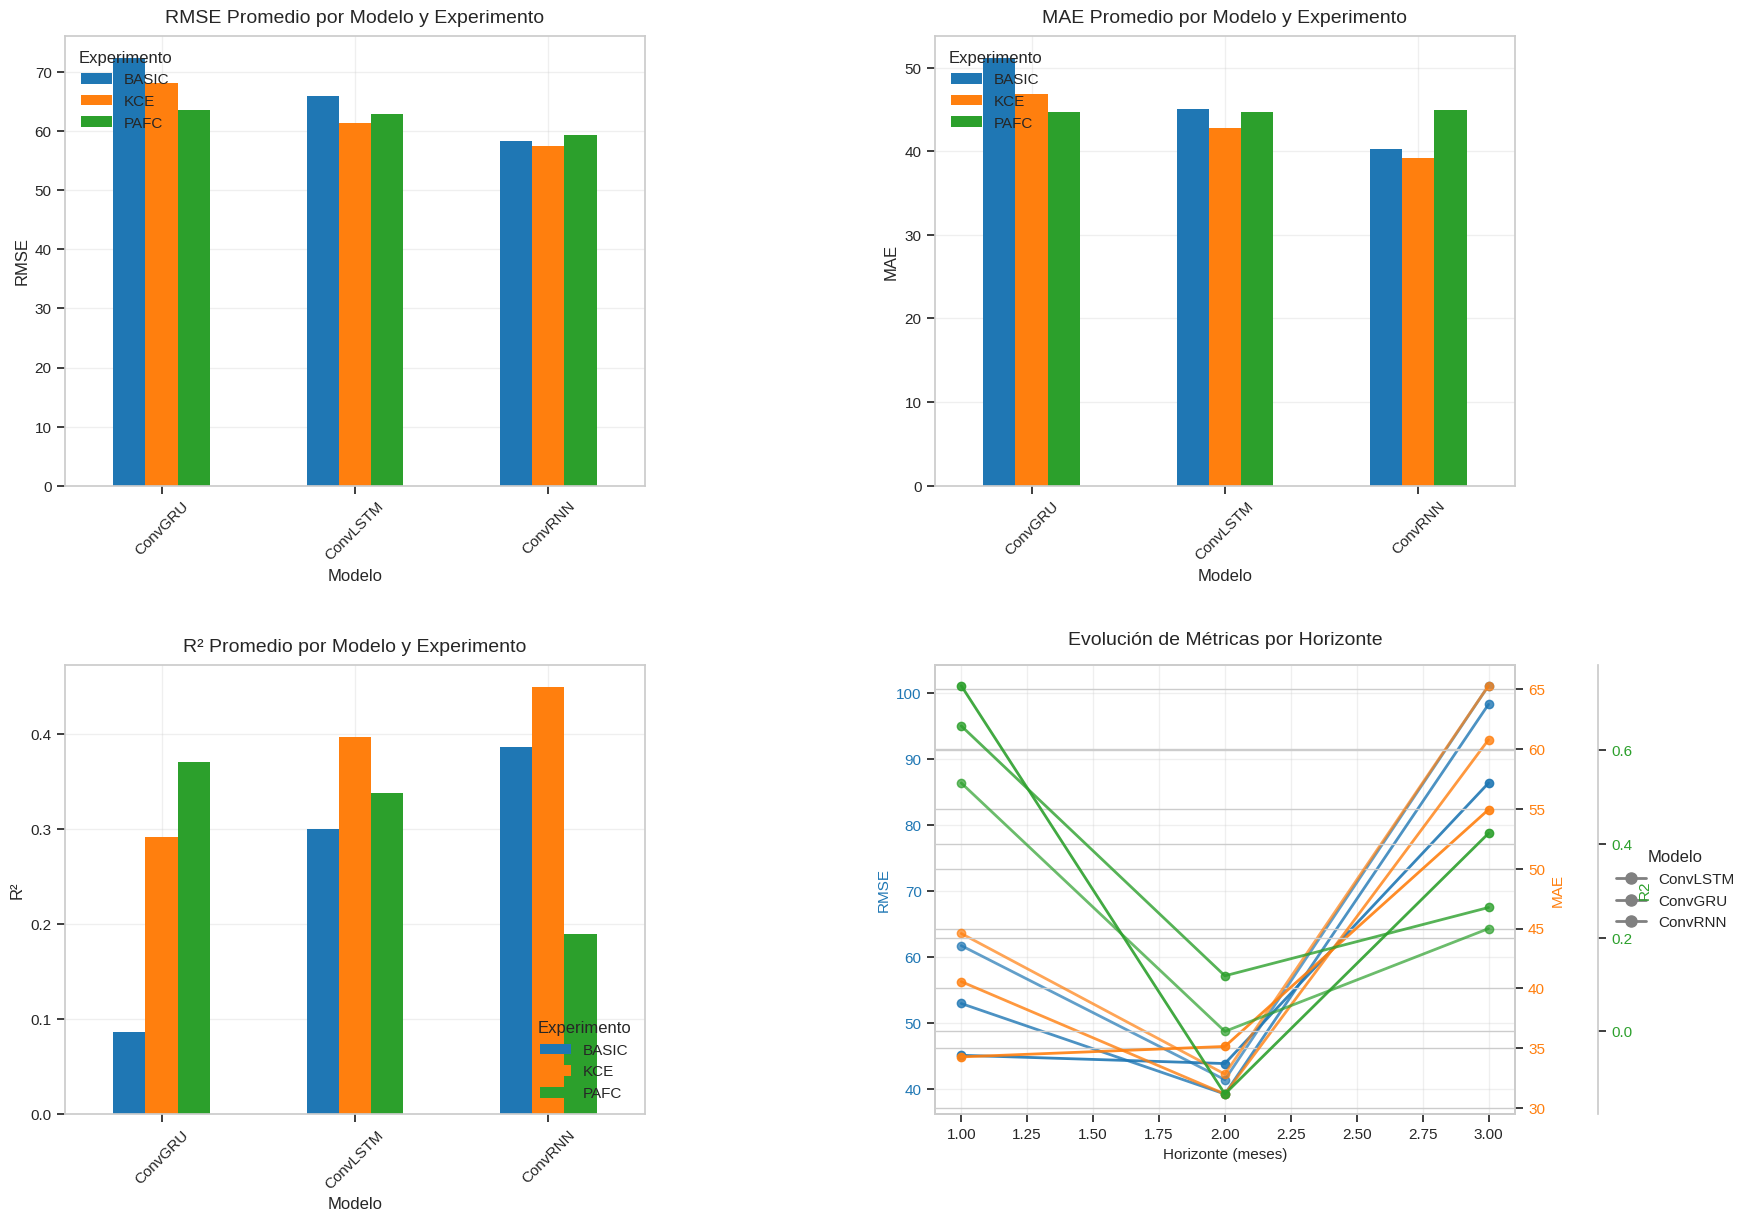


📋 TABLA RESUMEN - MEJORES MODELOS POR EXPERIMENTO:
────────────────────────────────────────────────────────────
              Model       RMSE        MAE        R2
Experiment                                         
BASIC       ConvRNN  33.100499  26.079712  0.864913
KCE         ConvRNN  36.944586  29.839870  0.221130
PAFC        ConvGRU  36.759266  30.979998  0.228924


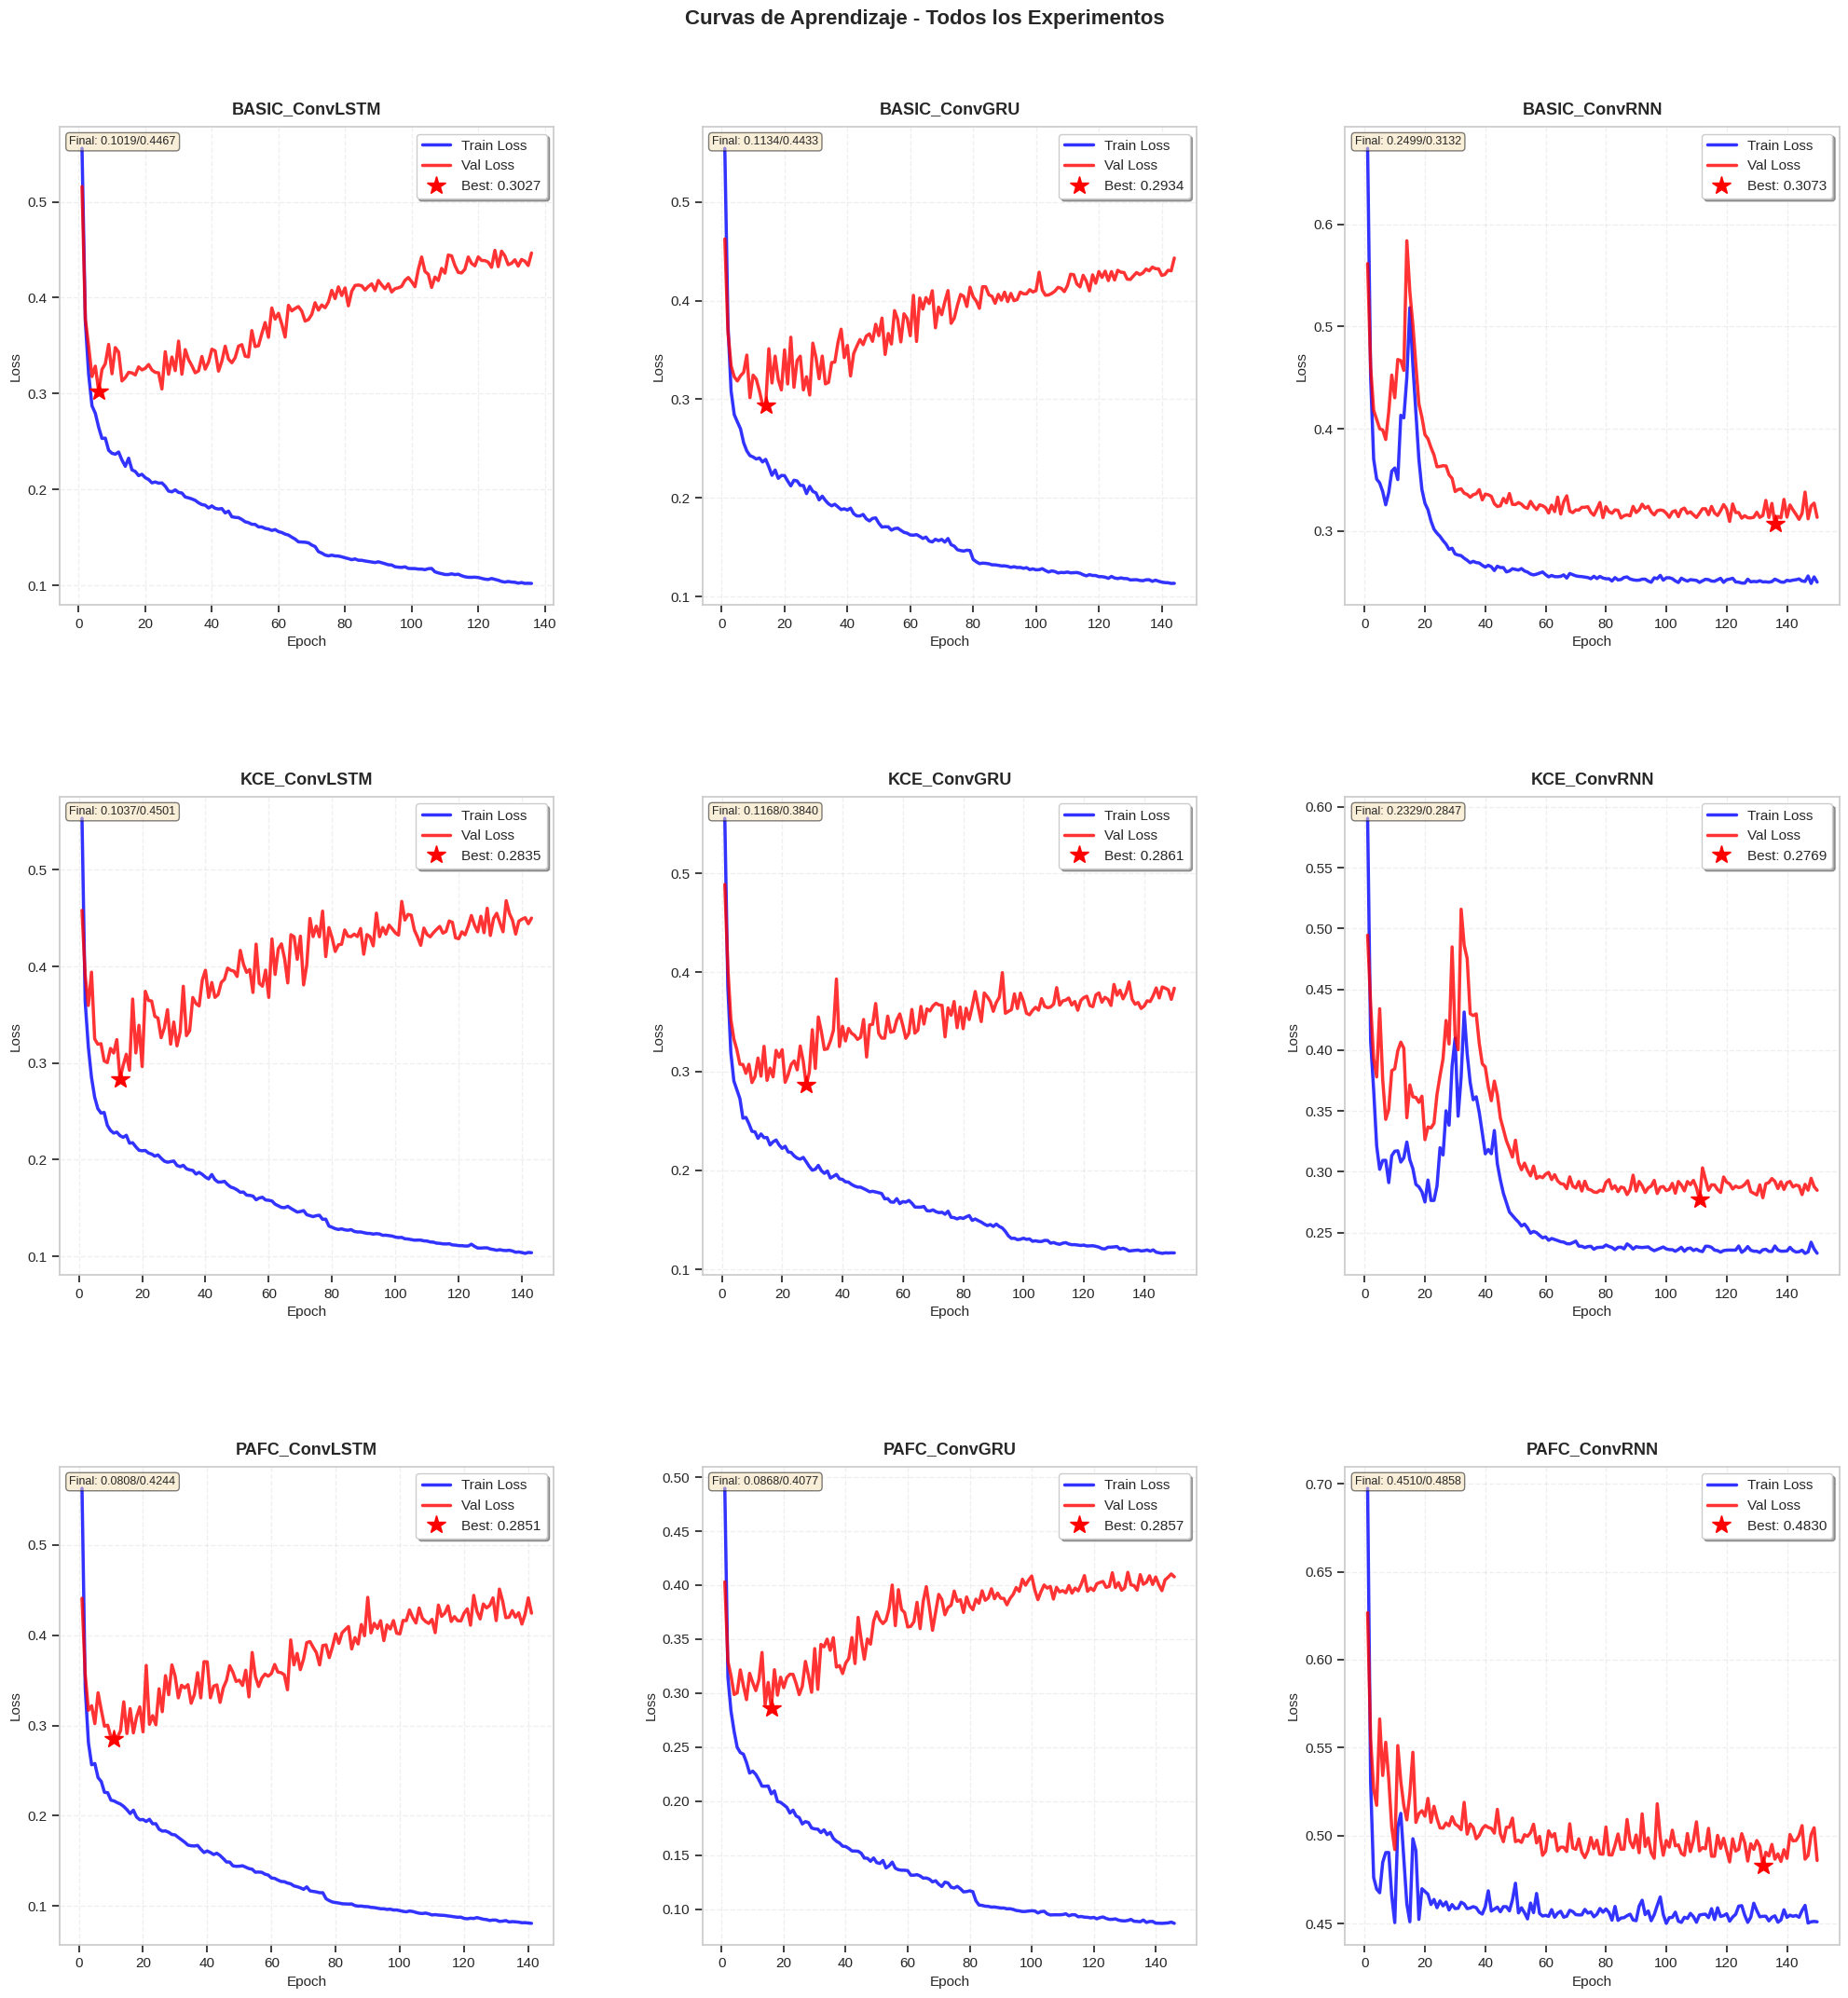


⏱️ RESUMEN DE ENTRENAMIENTO:
────────────────────────────────────────────────────────────────────────────────

🔬 Experimento: BASIC

   • ConvLSTM:
     - Parámetros del modelo: 78,579
     - Épocas entrenadas: 136
     - Mejor loss validación: 0.302720
     - Learning rate final: 0.0002500000118743628

   • ConvGRU:
     - Parámetros del modelo: 58,947
     - Épocas entrenadas: 144
     - Mejor loss validación: 0.293395
     - Learning rate final: 0.0002500000118743628

   • ConvRNN:
     - Parámetros del modelo: 9,679,399
     - Épocas entrenadas: 150
     - Mejor loss validación: 0.307290
     - Learning rate final: 0.0010000000474974513

🔬 Experimento: KCE

   • ConvLSTM:
     - Parámetros del modelo: 82,035
     - Épocas entrenadas: 143
     - Mejor loss validación: 0.283545
     - Learning rate final: 0.0002500000118743628

   • ConvGRU:
     - Parámetros del modelo: 61,539
     - Épocas entrenadas: 150
     - Mejor loss validación: 0.286118
     - Learning rate final: 0.0005000

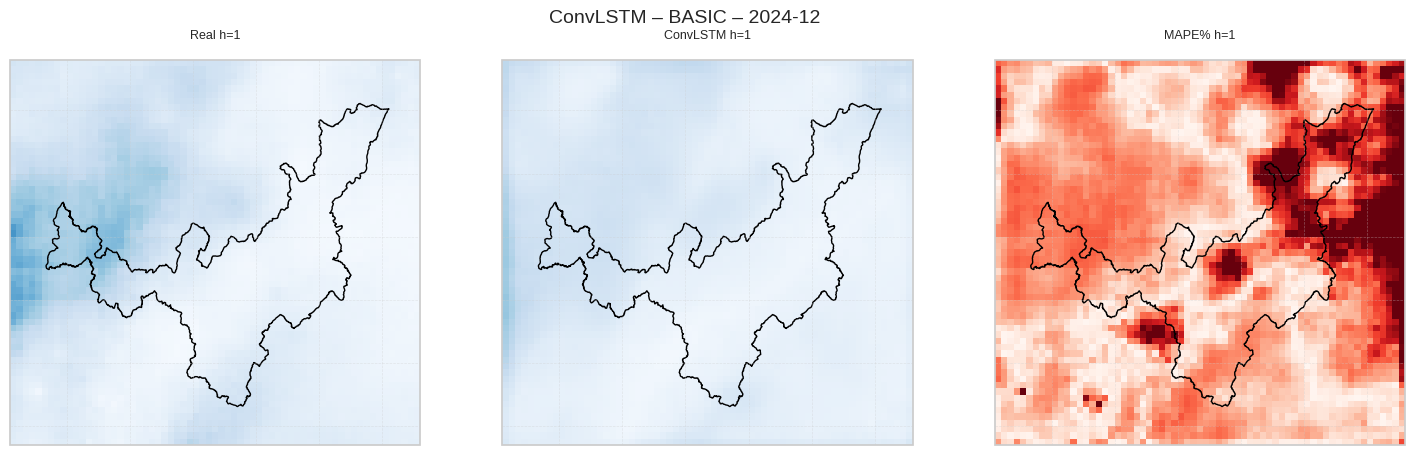

  ConvGRU:


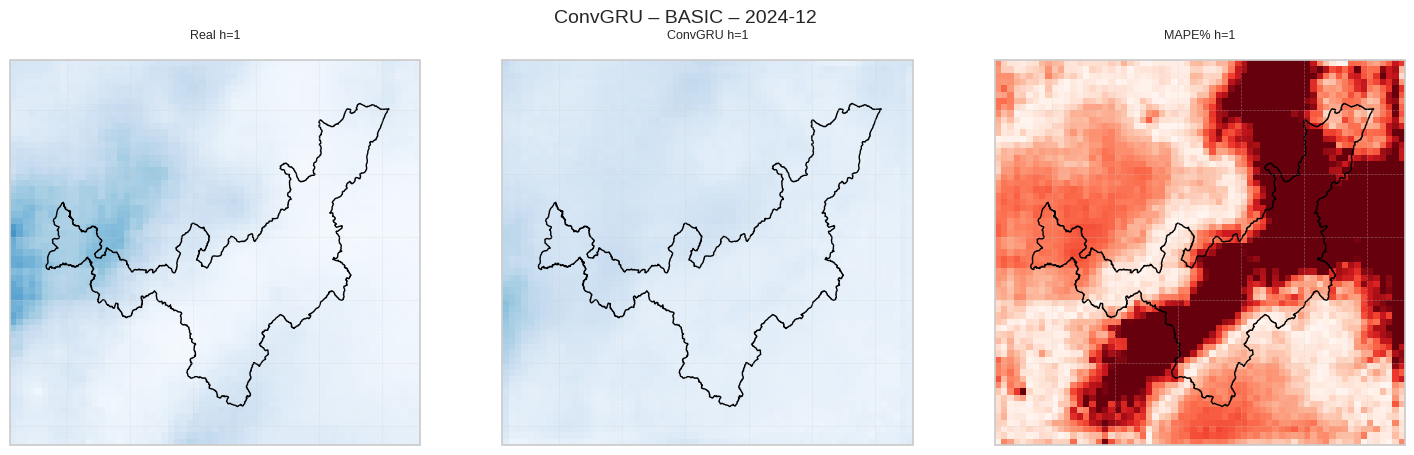

  ConvRNN:


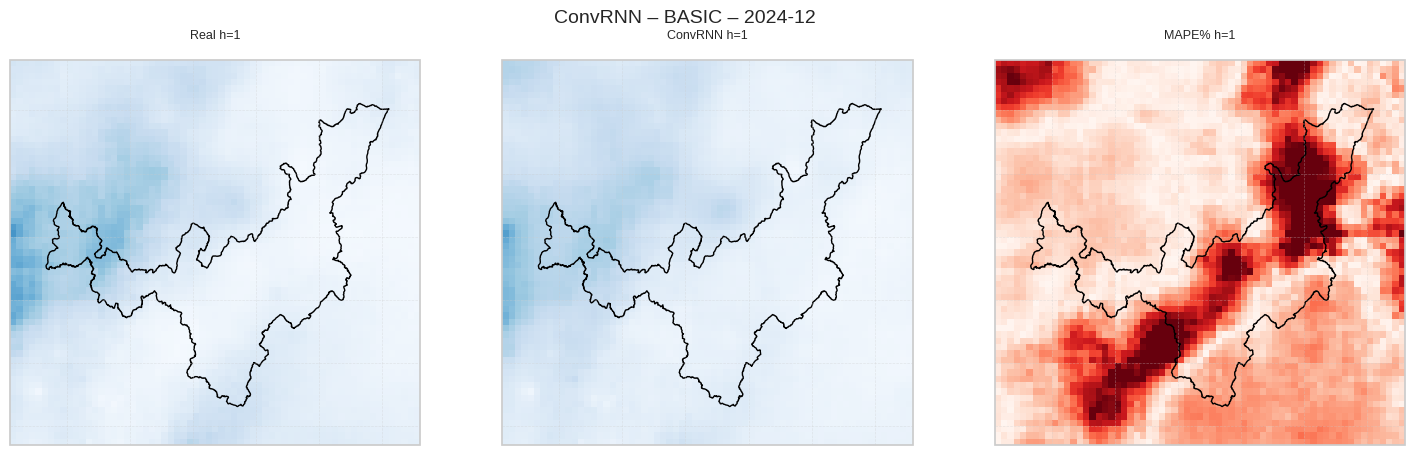


KCE:
  ConvLSTM:


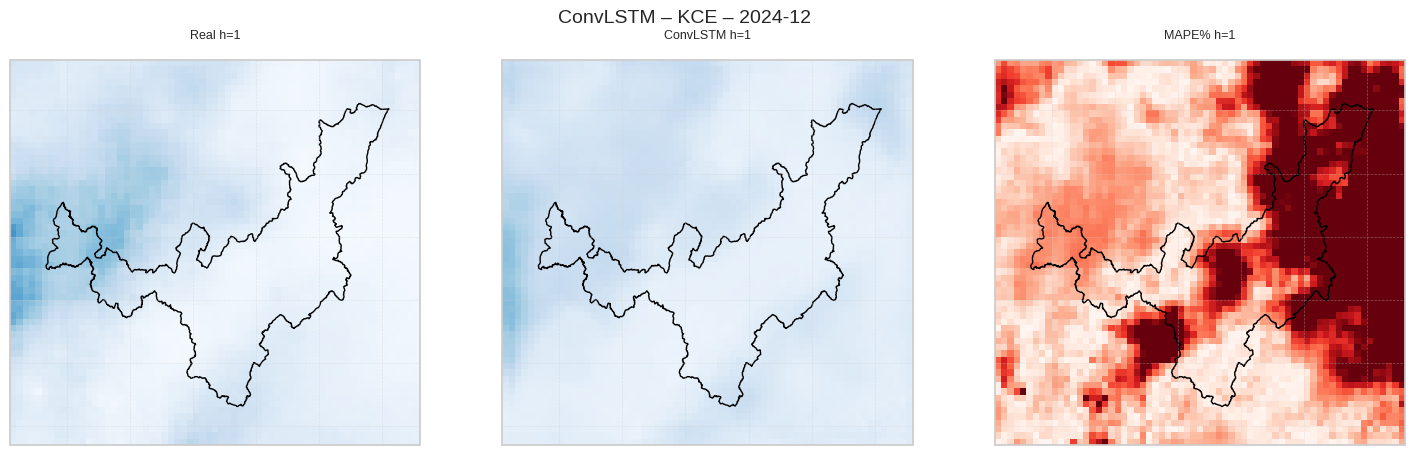

  ConvGRU:


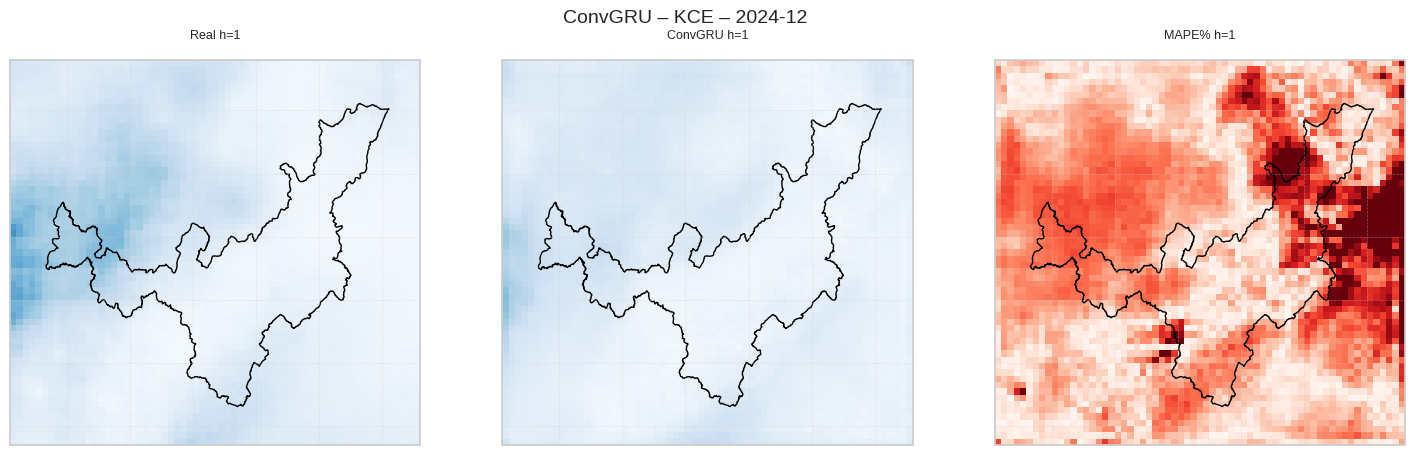

  ConvRNN:


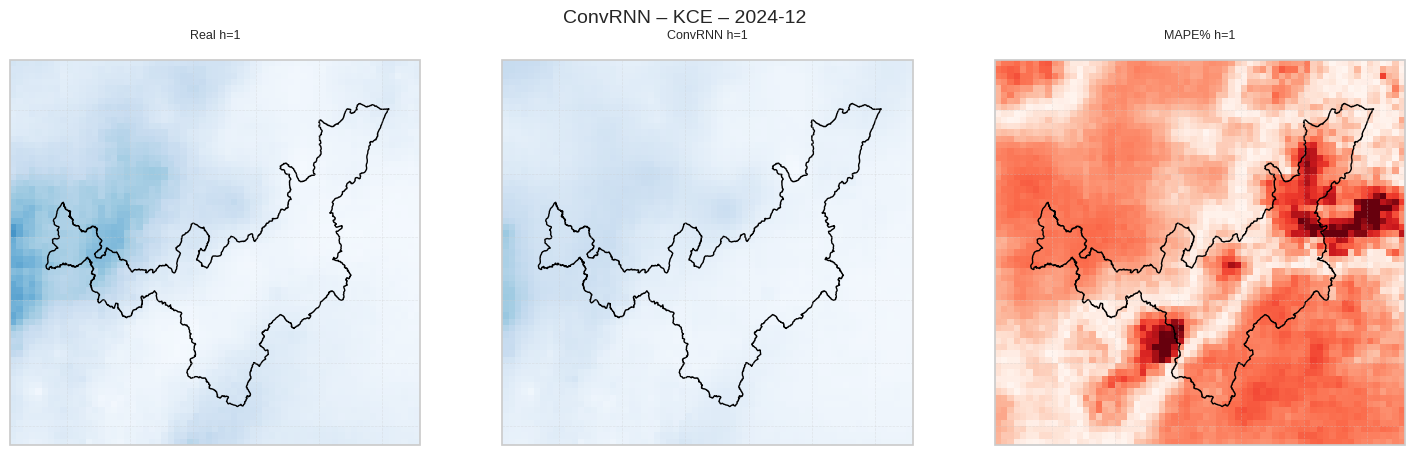


PAFC:
  ConvLSTM:


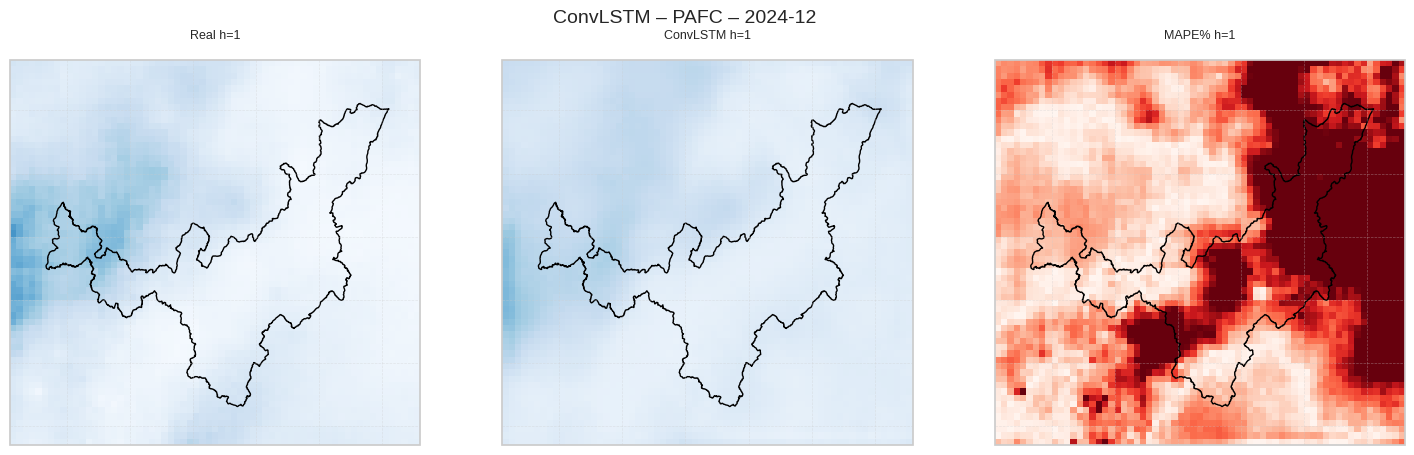

  ConvGRU:


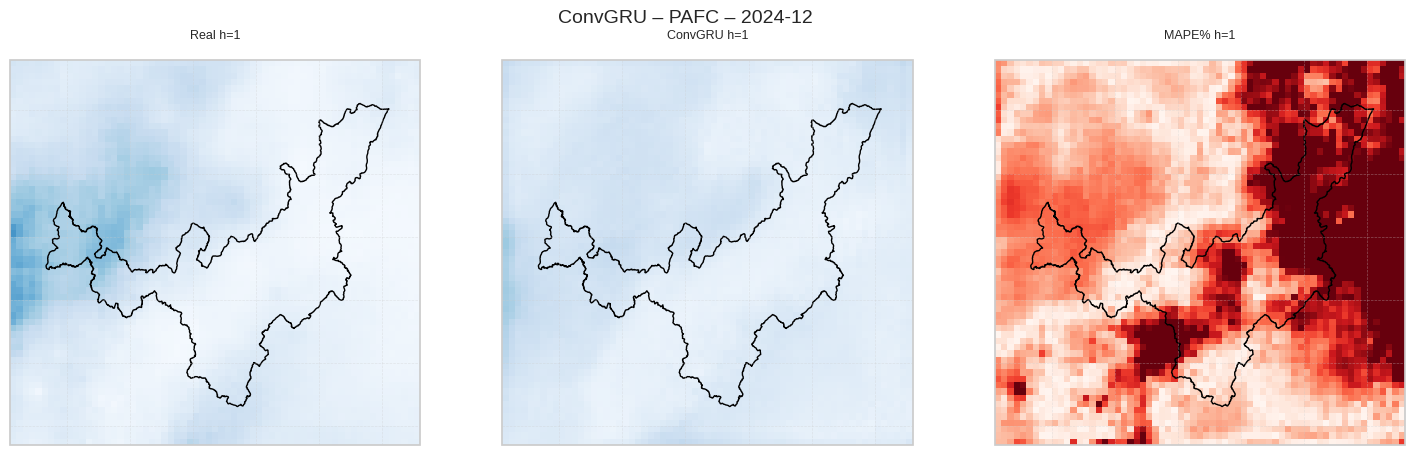

  ConvRNN:


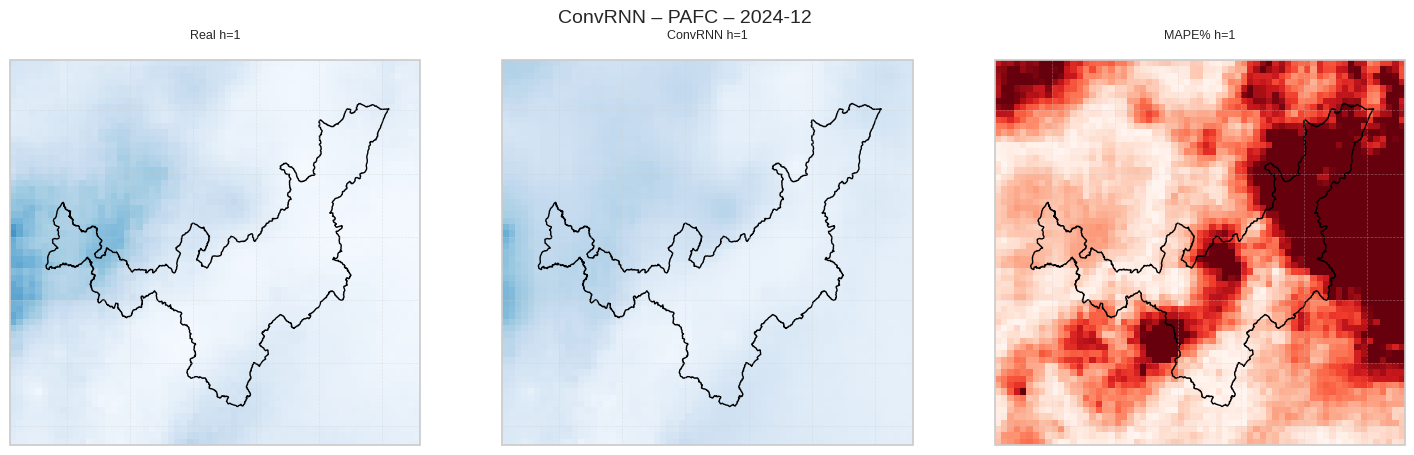

In [2]:
# ───────────────────────── VISUALIZACIÓN COMPARATIVA ─────────────────────────
print("\n" + "="*70)
print("📊 GENERANDO VISUALIZACIONES COMPARATIVAS")
print("="*70)

# Crear directorio para comparaciones
COMP_DIR = OUT_ROOT / 'comparisons'
COMP_DIR.mkdir(exist_ok=True)

# 1. Comparación de métricas entre modelos
if res_df is not None and len(res_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))

    # RMSE por modelo y experimento
    pivot_rmse = res_df.pivot_table(values='RMSE', index='Model', columns='Experiment', aggfunc='mean')
    pivot_rmse.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('RMSE Promedio por Modelo y Experimento', fontsize=14, pad=10)
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xlabel('Modelo')
    axes[0,0].legend(title='Experimento', loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)

    # MAE por modelo y experimento
    pivot_mae = res_df.pivot_table(values='MAE', index='Model', columns='Experiment', aggfunc='mean')
    pivot_mae.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('MAE Promedio por Modelo y Experimento', fontsize=14, pad=10)
    axes[0,1].set_ylabel('MAE')
    axes[0,1].set_xlabel('Modelo')
    axes[0,1].legend(title='Experimento', loc='upper left')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)

    # R² por modelo y experimento
    pivot_r2 = res_df.pivot_table(values='R2', index='Model', columns='Experiment', aggfunc='mean')
    pivot_r2.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('R² Promedio por Modelo y Experimento', fontsize=14, pad=10)
    axes[1,0].set_ylabel('R²')
    axes[1,0].set_xlabel('Modelo')
    axes[1,0].legend(title='Experimento', loc='lower right')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)

    # Métricas por horizonte - Crear subplot separado para mejor visualización
    ax_horizon = axes[1,1]

    # Limpiar el eje antes de plotear
    ax_horizon.clear()

    # Colores distintos para cada métrica
    colors_metrics = {'RMSE': 'tab:blue', 'MAE': 'tab:orange', 'R2': 'tab:green'}

    # Plotear cada métrica por separado con su propia escala
    for i, metric in enumerate(['RMSE', 'MAE', 'R2']):
        if i == 0:
            ax = ax_horizon
        else:
            ax = ax_horizon.twinx()
            if i == 2:
                # Mover el segundo eje Y a la derecha
                ax.spines['right'].set_position(('outward', 60))

        data = res_df.groupby(['H', 'Model'])[metric].mean().unstack()

        for model in data.columns:
            line = ax.plot(data.index, data[model],
                          marker='o',
                          label=f'{model} ({metric})',
                          color=colors_metrics[metric],
                          alpha=0.7 + 0.1*list(data.columns).index(model),
                          linewidth=2)

        ax.set_ylabel(metric, color=colors_metrics[metric], fontsize=11)
        ax.tick_params(axis='y', labelcolor=colors_metrics[metric])

        if i == 0:
            ax.set_xlabel('Horizonte (meses)', fontsize=11)
            ax.set_title('Evolución de Métricas por Horizonte', fontsize=14, pad=15)
            ax.grid(True, alpha=0.3)

    # Crear leyenda personalizada fuera del gráfico
    handles, labels = [], []
    for model in res_df['Model'].unique():
        handles.append(plt.Line2D([0], [0], marker='o', color='gray',
                                 label=model, markersize=8, linewidth=2))

    ax_horizon.legend(handles=handles, title='Modelo',
                     bbox_to_anchor=(1.15, 0.5), loc='center left')

    # Ajustar espaciado
    plt.subplots_adjust(hspace=0.4, wspace=0.5, right=0.85)
    plt.savefig(COMP_DIR / 'metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# 2. Tabla resumen de mejores modelos
print("\n📋 TABLA RESUMEN - MEJORES MODELOS POR EXPERIMENTO:")
print("─" * 60)

best_models = res_df.groupby('Experiment').apply(
    lambda x: x.loc[x['RMSE'].idxmin()]
)[['Model', 'RMSE', 'MAE', 'R2']]

print(best_models.to_string())

# 3. Comparación de curvas de aprendizaje
if all_histories:
    n_experiments = len(all_histories)
    n_cols = 3
    n_rows = (n_experiments + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows))

    # Asegurar que axes sea siempre un array 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten para iterar más fácilmente
    axes_flat = axes.flatten()

    for idx, (key, history) in enumerate(all_histories.items()):
        if idx < len(axes_flat):
            ax = axes_flat[idx]

            # Plot con estilo mejorado
            epochs = range(1, len(history.history['loss']) + 1)

            ax.plot(epochs, history.history['loss'],
                   'b-', label='Train Loss', linewidth=2.5, alpha=0.8)
            ax.plot(epochs, history.history['val_loss'],
                   'r-', label='Val Loss', linewidth=2.5, alpha=0.8)

            # Marcar el mejor punto
            best_epoch = np.argmin(history.history['val_loss']) + 1
            best_val_loss = min(history.history['val_loss'])
            ax.plot(best_epoch, best_val_loss, 'r*', markersize=15,
                   label=f'Best: {best_val_loss:.4f}')

            ax.set_xlabel('Epoch', fontsize=11)
            ax.set_ylabel('Loss', fontsize=11)
            ax.set_title(f'{key}', fontsize=13, fontweight='bold', pad=10)
            ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
            ax.grid(True, alpha=0.3, linestyle='--')

            # Añadir anotación con información adicional
            final_train = history.history['loss'][-1]
            final_val = history.history['val_loss'][-1]
            ax.text(0.02, 0.98, f'Final: {final_train:.4f}/{final_val:.4f}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=9)

    # Ocultar ejes no utilizados
    for idx in range(len(all_histories), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    plt.suptitle('Curvas de Aprendizaje - Todos los Experimentos',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.savefig(COMP_DIR / 'all_learning_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

# 4. Resumen de hiperparámetros y tiempos de entrenamiento
print("\n⏱️ RESUMEN DE ENTRENAMIENTO:")
print("─" * 80)

for exp in EXPERIMENTS.keys():
    metrics_dir = OUT_ROOT / exp / 'training_metrics'
    if metrics_dir.exists():
        print(f"\n🔬 Experimento: {exp}")
        for model in MODELS.keys():
            hp_file = metrics_dir / f"{model}_hyperparameters.json"
            history_file = metrics_dir / f"{model}_history.json"

            if hp_file.exists() and history_file.exists():
                with open(hp_file, 'r') as f:
                    hp = json.load(f)
                with open(history_file, 'r') as f:
                    hist = json.load(f)

                print(f"\n   • {model}:")
                print(f"     - Parámetros del modelo: {hp['model_params']:,}")
                print(f"     - Épocas entrenadas: {len(hist['loss'])}")
                print(f"     - Mejor loss validación: {min(hist['val_loss']):.6f}")
                # Verificar que 'lr' existe y tiene valores antes de acceder
                if 'lr' in hist and len(hist['lr']) > 0:
                    print(f"     - Learning rate final: {hist['lr'][-1]}")
                else:
                    print(f"     - Learning rate final: N/A")

# 5. Generar GIF comparativo de predicciones
print("\n🎬 Generando GIF comparativo...")

for exp in EXPERIMENTS.keys():
    exp_dir = OUT_ROOT / exp
    if exp_dir.exists():
        # Buscar todos los GIFs generados
        gif_files = list(exp_dir.glob("*.gif"))
        if gif_files:
            print(f"\n   📁 {exp}: {len(gif_files)} GIFs encontrados")
            for gif in gif_files:
                print(f"      • {gif.name}")

print("\n✅ Visualizaciones comparativas completadas!")
print(f"📂 Resultados guardados en: {COMP_DIR}")

# 6. Mostrar imágenes de predicción más recientes
print("\n🖼️ PREDICCIONES MÁS RECIENTES:")
for exp in EXPERIMENTS.keys():
    exp_dir = OUT_ROOT / exp
    if exp_dir.exists():
        print(f"\n{exp}:")
        # Mostrar primera imagen de cada modelo
        for model in MODELS.keys():
            img_path = exp_dir / f"{model}_1.png"
            if img_path.exists():
                from IPython.display import Image, display
                print(f"  {model}:")
                display(Image(str(img_path), width=800))



📊 Generando gráficos mejorados de evolución por horizonte...


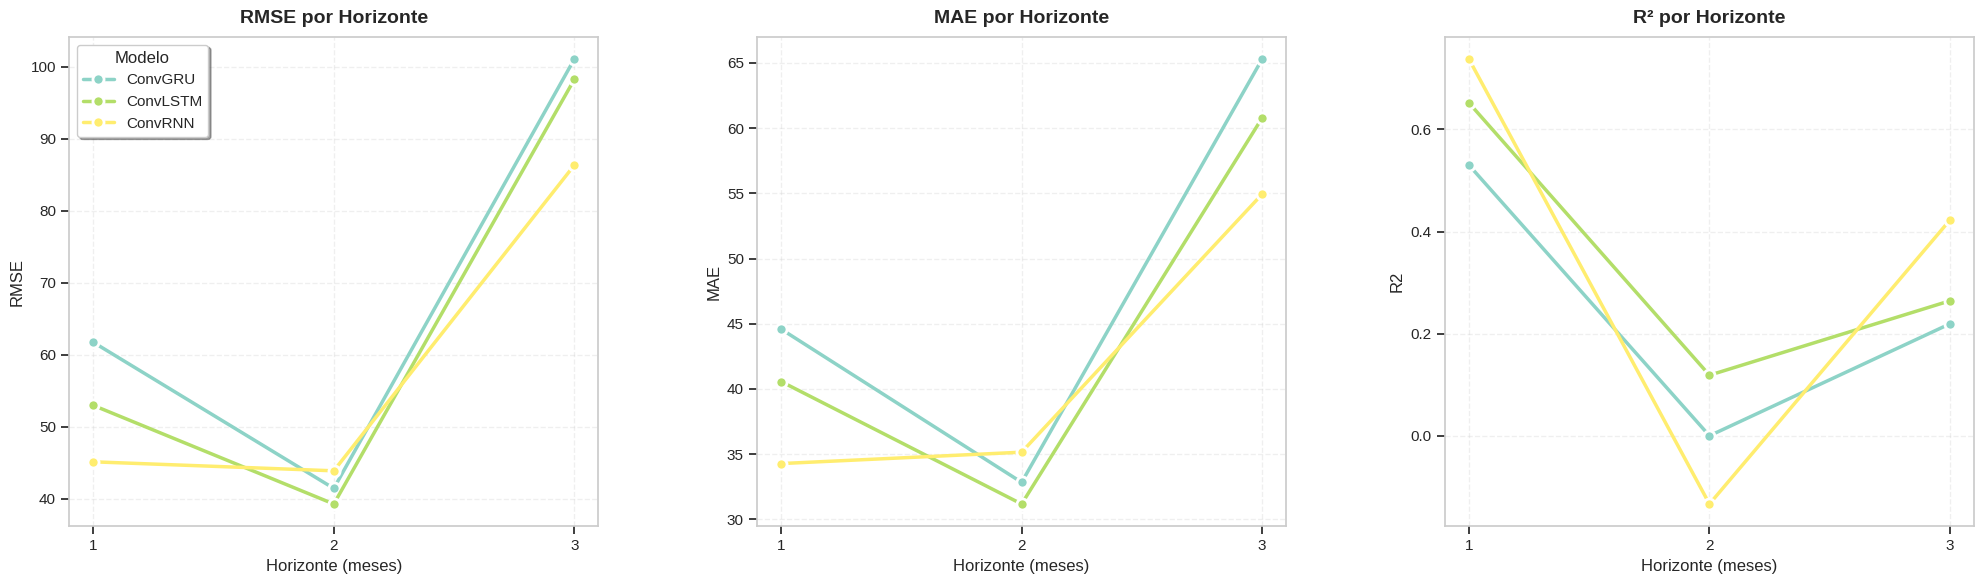

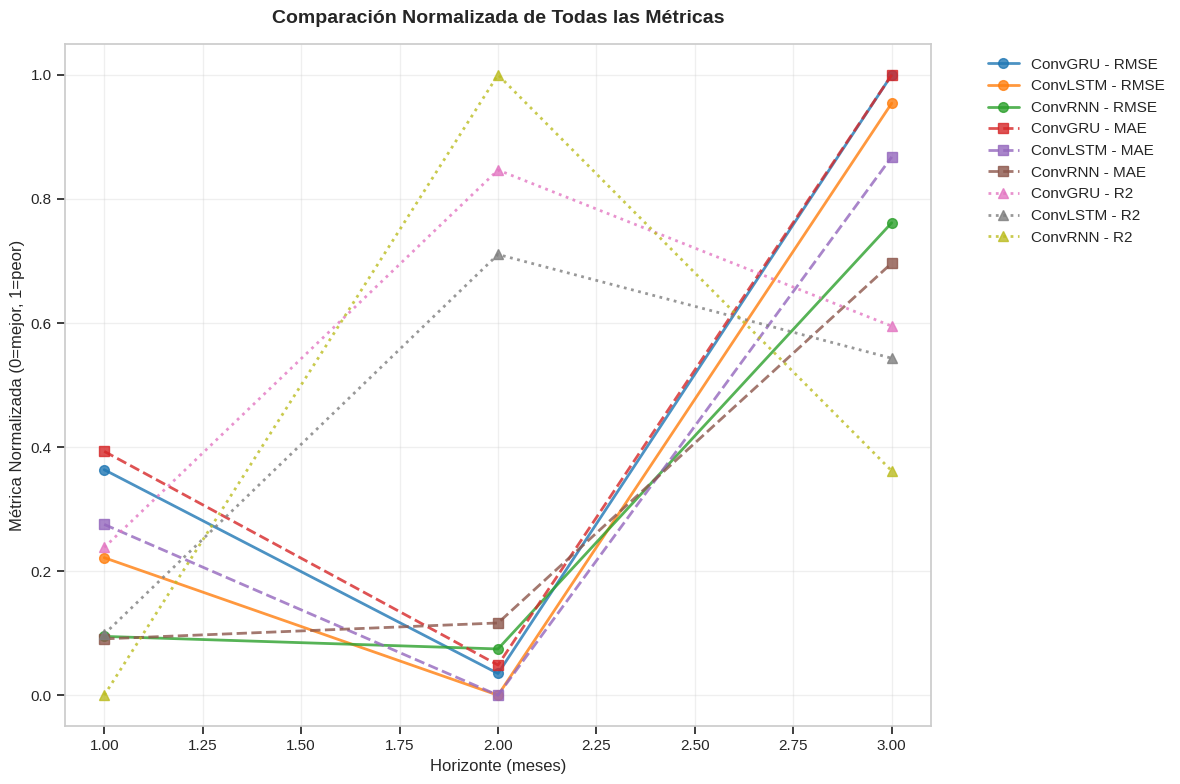

✅ Gráficos mejorados guardados en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/Spatial_CONVRNN/comparisons


In [3]:
# ───────────────────────── GRÁFICOS MEJORADOS DE EVOLUCIÓN POR HORIZONTE ─────────────────────────
print("\n📊 Generando gráficos mejorados de evolución por horizonte...")

if res_df is not None and len(res_df) > 0:
    # Crear figura con subplots separados para cada métrica
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    metrics = ['RMSE', 'MAE', 'R2']
    titles = ['RMSE por Horizonte', 'MAE por Horizonte', 'R² por Horizonte']
    colors = plt.cm.Set3(np.linspace(0, 1, len(res_df['Model'].unique())))

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]

        # Obtener datos pivoteados
        data = res_df.groupby(['H', 'Model'])[metric].mean().unstack()

        # Plotear cada modelo
        for i, model in enumerate(data.columns):
            ax.plot(data.index, data[model],
                   marker='o',
                   label=model,
                   color=colors[i],
                   linewidth=2.5,
                   markersize=8,
                   markeredgewidth=2,
                   markeredgecolor='white')

        ax.set_xlabel('Horizonte (meses)', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(data.index)

        # Leyenda solo en el primer gráfico
        if idx == 0:
            ax.legend(title='Modelo', loc='best', frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.savefig(COMP_DIR / 'metrics_evolution_by_horizon.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Crear gráfico adicional con todas las métricas normalizadas
    fig, ax = plt.subplots(figsize=(12, 8))

    # Normalizar métricas para comparación
    for metric in ['RMSE', 'MAE', 'R2']:
        data = res_df.groupby(['H', 'Model'])[metric].mean().unstack()

        # Normalizar cada métrica (min-max scaling)
        if metric == 'R2':
            # Para R2, mayor es mejor, así que invertimos
            data_norm = 1 - (data - data.min().min()) / (data.max().max() - data.min().min())
        else:
            # Para RMSE y MAE, menor es mejor
            data_norm = (data - data.min().min()) / (data.max().max() - data.min().min())

        for i, model in enumerate(data_norm.columns):
            linestyle = '-' if metric == 'RMSE' else '--' if metric == 'MAE' else ':'
            ax.plot(data_norm.index, data_norm[model],
                   marker='o' if metric == 'RMSE' else 's' if metric == 'MAE' else '^',
                   label=f'{model} - {metric}',
                   linewidth=2,
                   markersize=7,
                   linestyle=linestyle,
                   alpha=0.8)

    ax.set_xlabel('Horizonte (meses)', fontsize=12)
    ax.set_ylabel('Métrica Normalizada (0=mejor, 1=peor)', fontsize=12)
    ax.set_title('Comparación Normalizada de Todas las Métricas', fontsize=14, pad=15, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.savefig(COMP_DIR / 'normalized_metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

print("✅ Gráficos mejorados guardados en:", COMP_DIR)



📊 Generando tabla visual de métricas...


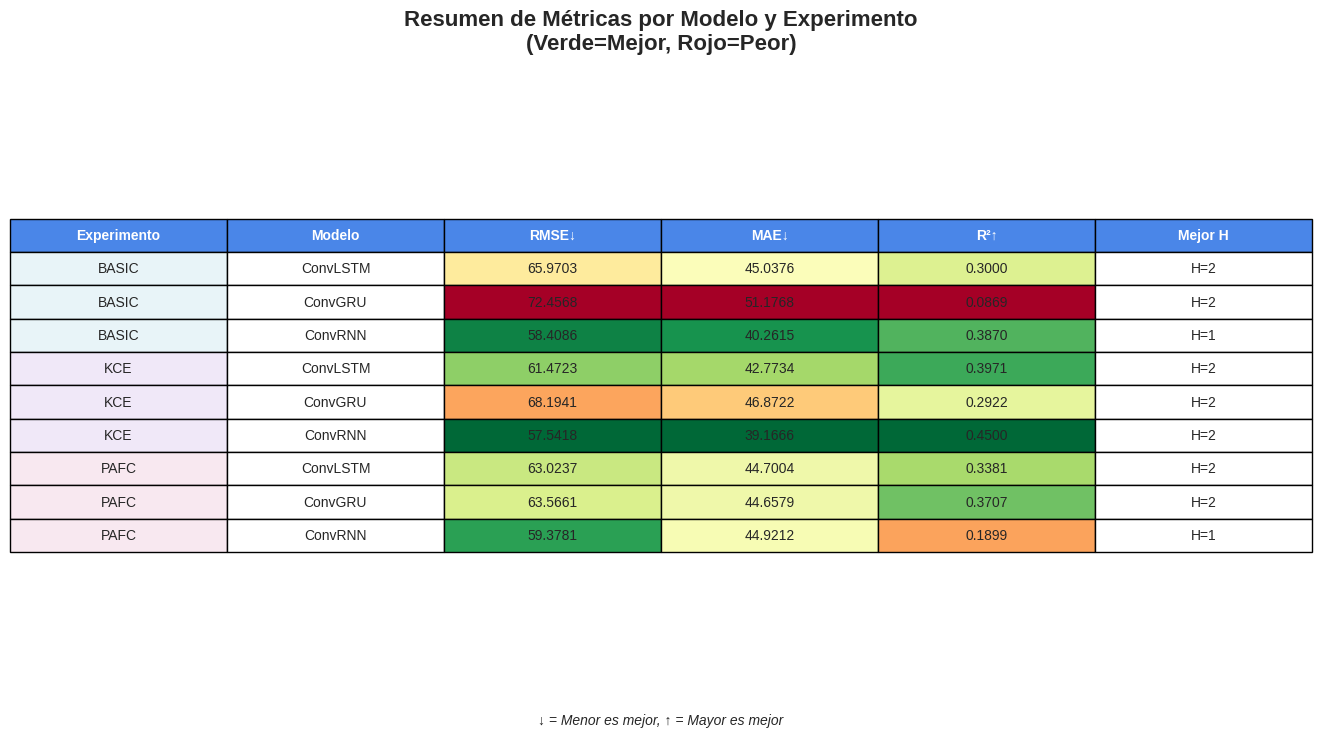


🏆 MEJOR MODELO GLOBAL:
──────────────────────────────────────────────────
Modelo: ConvRNN
Experimento: BASIC
Horizonte: 1
RMSE: 33.1005
MAE: 26.0797
R²: 0.8649
Score compuesto: 1.0000

✅ Todas las visualizaciones han sido generadas y guardadas!


In [4]:
# ───────────────────────── TABLA VISUAL DE MÉTRICAS ─────────────────────────
print("\n📊 Generando tabla visual de métricas...")

if res_df is not None and len(res_df) > 0:
    # Crear tabla resumen con colores
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')

    # Preparar datos para la tabla
    summary_data = []
    experiments = res_df['Experiment'].unique()
    models = res_df['Model'].unique()

    # Headers
    headers = ['Experimento', 'Modelo', 'RMSE↓', 'MAE↓', 'R²↑', 'Mejor H']

    for exp in experiments:
        for model in models:
            exp_model_data = res_df[(res_df['Experiment'] == exp) & (res_df['Model'] == model)]
            if not exp_model_data.empty:
                avg_rmse = exp_model_data['RMSE'].mean()
                avg_mae = exp_model_data['MAE'].mean()
                avg_r2 = exp_model_data['R2'].mean()
                best_h = exp_model_data.loc[exp_model_data['RMSE'].idxmin(), 'H']

                summary_data.append([
                    exp, model,
                    f'{avg_rmse:.4f}',
                    f'{avg_mae:.4f}',
                    f'{avg_r2:.4f}',
                    f'H={best_h}'
                ])

    # Crear tabla
    table = ax.table(cellText=summary_data, colLabels=headers,
                    cellLoc='center', loc='center')

    # Estilizar tabla
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)

    # Colorear celdas según rendimiento
    for i in range(len(summary_data)):
        # Obtener valores para comparación
        rmse_val = float(summary_data[i][2])
        mae_val = float(summary_data[i][3])
        r2_val = float(summary_data[i][4])

        # Encontrar min/max para normalización
        all_rmse = [float(row[2]) for row in summary_data]
        all_mae = [float(row[3]) for row in summary_data]
        all_r2 = [float(row[4]) for row in summary_data]

        # Normalizar y colorear RMSE (menor es mejor)
        rmse_norm = (rmse_val - min(all_rmse)) / (max(all_rmse) - min(all_rmse))
        rmse_color = plt.cm.RdYlGn(1 - rmse_norm)
        table[(i+1, 2)].set_facecolor(rmse_color)

        # Normalizar y colorear MAE (menor es mejor)
        mae_norm = (mae_val - min(all_mae)) / (max(all_mae) - min(all_mae))
        mae_color = plt.cm.RdYlGn(1 - mae_norm)
        table[(i+1, 3)].set_facecolor(mae_color)

        # Normalizar y colorear R² (mayor es mejor)
        r2_norm = (r2_val - min(all_r2)) / (max(all_r2) - min(all_r2))
        r2_color = plt.cm.RdYlGn(r2_norm)
        table[(i+1, 4)].set_facecolor(r2_color)

        # Colorear experimento
        exp_colors = {'BASIC': '#e8f4f8', 'KCE': '#f0e8f8', 'PAFC': '#f8e8f0'}
        table[(i+1, 0)].set_facecolor(exp_colors.get(summary_data[i][0], 'white'))

    # Colorear headers
    for j in range(len(headers)):
        table[(0, j)].set_facecolor('#4a86e8')
        table[(0, j)].set_text_props(weight='bold', color='white')

    plt.title('Resumen de Métricas por Modelo y Experimento\n(Verde=Mejor, Rojo=Peor)',
             fontsize=16, fontweight='bold', pad=20)

    # Añadir leyenda
    plt.text(0.5, -0.05, '↓ = Menor es mejor, ↑ = Mayor es mejor',
            transform=ax.transAxes, ha='center', fontsize=10, style='italic')

    plt.savefig(COMP_DIR / 'metrics_summary_table.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Identificar el mejor modelo global
    print("\n🏆 MEJOR MODELO GLOBAL:")
    print("─" * 50)

    # Calcular score compuesto (normalizado)
    res_df['score'] = (
        (1 - (res_df['RMSE'] - res_df['RMSE'].min()) / (res_df['RMSE'].max() - res_df['RMSE'].min())) +
        (1 - (res_df['MAE'] - res_df['MAE'].min()) / (res_df['MAE'].max() - res_df['MAE'].min())) +
        ((res_df['R2'] - res_df['R2'].min()) / (res_df['R2'].max() - res_df['R2'].min()))
    ) / 3

    best_overall = res_df.loc[res_df['score'].idxmax()]
    print(f"Modelo: {best_overall['Model']}")
    print(f"Experimento: {best_overall['Experiment']}")
    print(f"Horizonte: {best_overall['H']}")
    print(f"RMSE: {best_overall['RMSE']:.4f}")
    print(f"MAE: {best_overall['MAE']:.4f}")
    print(f"R²: {best_overall['R2']:.4f}")
    print(f"Score compuesto: {best_overall['score']:.4f}")

print("\n✅ Todas las visualizaciones han sido generadas y guardadas!")
